# Word Embeddings

This notebook handles word embedding using the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump.

## Table of Contents
* [Data Import](#data_import)
* [Data Preparation](#data_preparation)
* [Word Embedding](#methods)

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import math
import time
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH

<a id='data_import'/>

## Data Import

In [180]:
from academia_tag_recommender.preprocessor import BasicPreprocessor
from academia_tag_recommender.tokenizer import BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer
from academia_tag_recommender.vectorizer_computation import get_vect_feat_with_params
from academia_tag_recommender.data import documents

<a id='data_preparation'/>

## Data Preparation

In [237]:
from academia_tag_recommender.test_train_data import get_y, get_test_train_data

X = np.vstack([document.text for document in documents])
y = get_y()
X_train, X_test, y_train, y_test = get_test_train_data(X, y, scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='methods'/>

## Word Embedding

* [Word2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)
* [Doc2Vec]()
* [FastText]()

**Word2Vec**

In [272]:
from nltk.tokenize import sent_tokenize
from academia_tag_recommender.stopwords import stopwordlist
from gensim.utils import simple_preprocess

def sent2tokens(sentence):
    tokens = []
    for word in simple_preprocess(sentence):
        if word in stopwordlist:
            continue
        tokens.append(word)
    return tokens

def word2tokens(document, flat=True):
    sentences = []
    for sentence in sent_tokenize(document, language='english'):
        sentence = sent2tokens(sentence)
        if flat:
            sentences = sentences + sentence
        else:
            sentences.append(sentence)
    return sentences

class Word2Tok:
    def __init__(self, data, flat=True):
            self.data = data
            self.flat = flat
    
    def __iter__(self):
        for document in self.data:
            sentences = word2tokens(document[0], self.flat)
            if self.flat:
                yield sentences
            else:
                for sentence in sentences:
                    yield sentence
        

In [273]:
X_train_word2sen = Word2Tok(X_train, flat=False)
X_train_word2tok = Word2Tok(X_train)
X_test_word2tok = Word2Tok(X_test)

In [274]:
print(list(X_train_word2sen)[:1])
print(list(X_train_word2tok)[:1])
print(list(X_test_word2tok)[:1])

[['can', 'find', 'impact', 'factor', 'given', 'journal', 'title']]
[['can', 'find', 'impact', 'factor', 'given', 'journal', 'title', 'journals', 'provide', 'impact', 'factor', 'homepage', 'don', 'can', 'find', 'impact', 'factor']]
[['kind', 'visa', 'required', 'work', 'academia', 'japan', 'title', 'kind', 'visa', 'class', 'apply', 'order', 'work', 'academic', 'japan']]


In [275]:
import gensim.models

model = gensim.models.Word2Vec(sentences=X_train_word2sen, size=200)

In [276]:
wv = model.wv
wv.init_sims(replace=True)
print(len(wv.vocab))

12830


In [278]:
# code taken from: https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
def word_averaging(words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.word_vec(word, use_norm=True))
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(samples):
    return np.vstack([word_averaging(sample) for sample in samples])

In [279]:
X_train_word2vec = word_averaging_list(X_train_word2tok)
X_test_word2vec = word_averaging_list(X_test_word2tok)

In [ ]:
from academia_tag_recommender.classifier import Classifier
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
RANDOM_STATE = 0
preprocessing = PreprocessingDefinition('word2vec', 'basic', 'basic', 'english', '1,1', 'None')

def create_word2vec_classifier(classifier, name=False):
    clf = Classifier(classifier, preprocessing, name)
    clf.fit(X_train_word2vec, y_train)
    clf.score(X_test_word2vec, y_test)
    path = clf.save('word2vec')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

In [281]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

create_word2vec_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'Word2Vec(MultioutputClasifier(LogisticRegression))')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training: 68.3249671459198s
Test: 1.9155175685882568s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012166359065741742     0.06783555018137848      0.3251370415155179       0.1719850866586054       0.21151427035949408      
micro                                                            0.687046004842615        0.16236707834628772      0.262660546920199        
macro                                                            0.2520229867705682       0.04898868813796354      0.07141398442762384      


In [282]:
from sklearn.svm import LinearSVC

create_word2vec_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'Word2Vec(MultioutputClasifier(LinearSVC))')

Training: 84.26376461982727s
Test: 1.5284662246704102s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011899700884617833     0.07388149939540507      0.3560338573155985       0.1871322047561467       0.23096159382737372      
micro                                                            0.7241175310589627       0.17509894616374994      0.28200599032332385      
macro                                                            0.2551460535866724       0.06204666765605349      0.08632246738906955      


In [283]:
from sklearn.ensemble import RandomForestClassifier

create_word2vec_classifier(RandomForestClassifier(random_state=RANDOM_STATE), 'Word2Vec(RandomForestClassifier)')

Training: 811.9436721801758s
Test: 11.550355911254883s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012867052758862088     0.05175332527206771      0.14371221281741234      0.06577992744860942      0.08561985374560949      
micro                                                            0.7130730050933786       0.06008297172285537      0.11082768933063594      
macro                                                            0.09051132958512395      0.011769326292861875     0.01897526431028349      


In [163]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

scorer = make_scorer(accuracy_score)

In [ ]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption

classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                      ClassifierOption(LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], random_state=RANDOM_STATE, max_iter=2000, scoring=scorer))]
                      #ClassifierOption(RandomForestClassifier(random_state=RANDOM_STATE))]

create_word2vec_classifier(ClasswiseClassifier(classifier_options), 'Word2Vec(ClasswiseClassifier)')

**Doc2Vec**

In [245]:
# code taken from: https://radimrehurek.com/gensim_3.8.3/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
from gensim.models.doc2vec import TaggedDocument

def doc2tokens(document):
        tokens = []
        for sentence in tokenize(document):
            tokens = tokens + sentence
        return tokens

class Doc2Tagged:
    def __init__(self, data, only_tokens=False):
            self.data = data
            self.only_tokens = only_tokens
    
    def __iter__(self):
        for i, document in enumerate(self.data):
            tokens = doc2tokens(document[0])
            if self.only_tokens:
                yield tokens
            else:
                yield TaggedDocument(tokens, y_train[i])
        

In [246]:
X_train_doc2tok = Doc2Tagged(X_train)
X_test_doc2tok = Doc2Tagged(X_test, only_tokens=True)
print(list(X_train_doc2tok)[:1])
print(list(X_test_doc2tok)[:1])

24812
8270
[TaggedDocument(words=['can', 'find', 'impact', 'factor', 'given', 'journal', 'title', 'journals', 'provide', 'impact', 'factor', 'homepage', 'don', 'can', 'find', 'impact', 'factor'], tags=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])), TaggedDocument(words=['many', 'engineering', 'departments', 'care', 'professional', 'engineer', 'registration', 'seen', 'many', 'engineering', 'departments', 'want

In [247]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(vector_size=100, min_count=2, epochs=20)
model.build_vocab(X_train_doc2tok)
model.train(X_train_doc2tok, total_examples=model.corpus_count, epochs=model.epochs)

In [248]:
def doc2vector(samples):
    return [model.infer_vector(sample) for sample in samples]

In [249]:
X_train_doc2vec = doc2vector([sample.words for sample in X_train_doc2tok])
X_test_doc2vec = doc2vector([sample for sample in X_test_doc2tok])

In [ ]:
from academia_tag_recommender.classifier import Classifier
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
RANDOM_STATE = 0
preprocessing = PreprocessingDefinition('doc2vec', 'basic', 'basic', 'english', '1,1', 'None')

def create_doc2vec_classifier(classifier, name=False):
    clf = Classifier(classifier, preprocessing, name)
    clf.fit(X_train_doc2vec, y_train)
    clf.score(X_test_doc2vec, y_test)
    path = clf.save('doc2vec')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

In [252]:
create_doc2vec_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'Doc2Vec(MultioutputClasifier(LogisticRegression))')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Training: 107.11739015579224s
Test: 0.8377618789672852s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012979698338955006     0.04921402660217654      0.18158302821330063      0.10044740024183797      0.11970254654656105      
micro                                                            0.5782183595871809       0.10152114825234848      0.1727173163509512       
macro                                                            0.27877947542586823      0.05245819112000173      0.08107172534381756      


In [253]:
create_doc2vec_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'Doc2Vec(MultioutputClasifier(LinearSVC))')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of 

Training: 1070.8179414272308s
Test: 0.7377164363861084s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012826958569337491     0.0498186215235792       0.14551390568319225      0.07139258363563078      0.09023406460528587      
micro                                                            0.6883656509695291       0.07109818320537886      0.12888447076111856      
macro                                                            0.1859857164234946       0.028385444151936556     0.04365316691887272      


In [254]:
from sklearn.ensemble import RandomForestClassifier

create_doc2vec_classifier(RandomForestClassifier(random_state=RANDOM_STATE), 'Doc2Vec(RandomForestClassifier)')

Training: 656.6127502918243s
Test: 11.291404008865356s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013312543753579839     0.03905683192261185      0.012877871825876663     0.0048226521563885525    0.006703518166637877     
micro                                                            0.653179190751445        0.005388393495779887     0.010688611426409384     
macro                                                            0.025360684319494387     0.0006558232949512208    0.0012453271909479047    


In [ ]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                      ClassifierOption(LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], random_state=RANDOM_STATE, max_iter=2000, scoring=scorer))]
                      #ClassifierOption(RandomForestClassifier(random_state=RANDOM_STATE))]

create_doc2vec_classifier(ClasswiseClassifier(classifier_options), 'Doc2Vec(ClasswiseClassifier)')

**FastText**

## Evaluation

**Word2Vec**

In [290]:
from academia_tag_recommender.classifier import available_classifier_paths
paths = available_classifier_paths('word2vec')
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

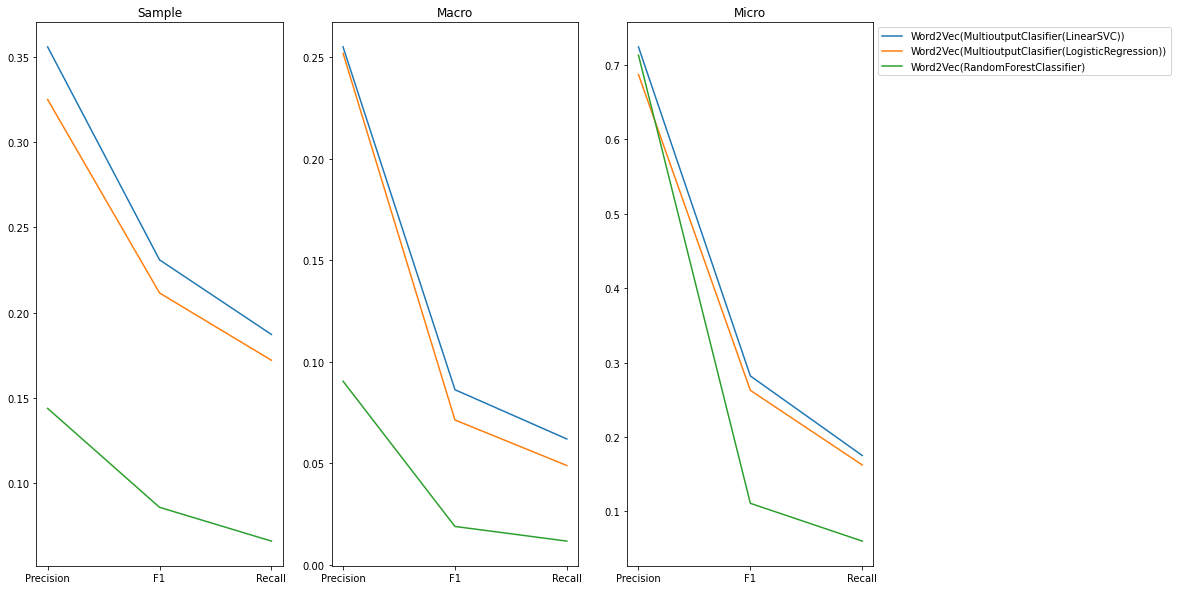

In [291]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [292]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.sum(), reverse=True)[:3]

In [293]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(X_test_word2vec)
    classwise_results.append((clf, classification_report(y_test, prediction, output_dict=True, zero_division=0)))

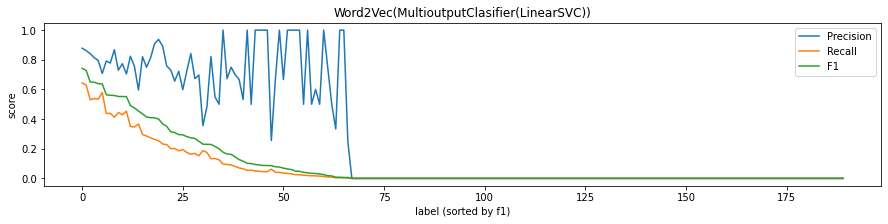

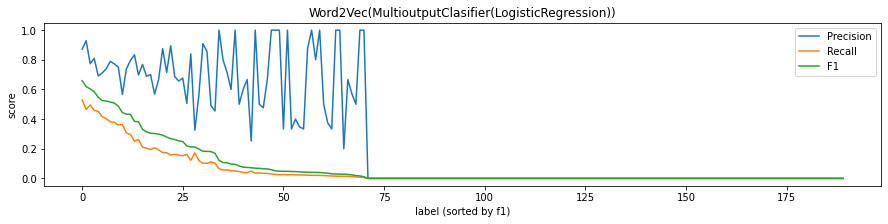

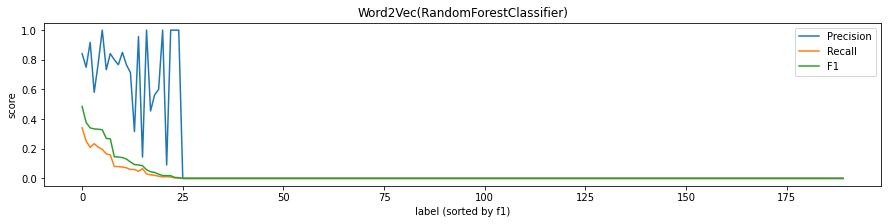

In [294]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['f1-score'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.set_xlabel('label (sorted by f1)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()

**Doc2Vec**

In [295]:
from academia_tag_recommender.classifier import available_classifier_paths
paths = available_classifier_paths('doc2vec')
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

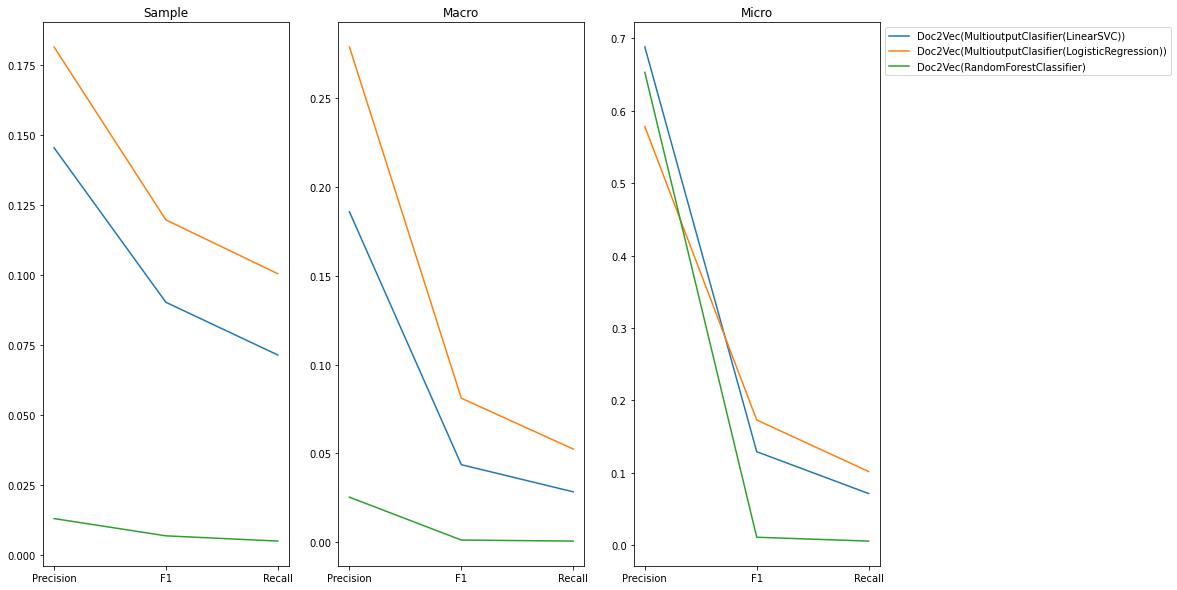

In [296]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [300]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.sum(), reverse=True)[:3]

In [301]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(X_test_doc2vec)
    classwise_results.append((clf, classification_report(y_test, prediction, output_dict=True, zero_division=0)))

In [302]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['f1-score'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.set_xlabel('label (sorted by f1)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()